# 5章 誤差逆伝播法

In [1]:
abstract AbstractLayer

## 5.4 単純なレイヤの実装

### 5.4.1 乗算レイヤの実装

In [2]:
type MulLayer{T} <: AbstractLayer
    x::T
    y::T
end

(::Type{MulLayer{T}}){T}() = MulLayer(zero(T), zero(T))

In [3]:
function forward{T}(lyr::MulLayer{T}, x::T, y::T)
    lyr.x = x
    lyr.y = y
    x * y
end
@inline forward{T}(lyr::MulLayer{T}, x, y) = forward(lyr, T(x), T(y))

forward (generic function with 2 methods)

In [4]:
function backward{T}(lyr::MulLayer{T}, dout::T)
    dx = dout * lyr.y
    dy = dout * lyr.x
    (dx, dy)
end

backward (generic function with 1 method)

In [5]:
apple = 100;
apple_num = 2;
tax = 1.1;

In [6]:
# layer
mul_apple_layer = MulLayer{Float64}()
mul_tax_layer = MulLayer{Float64}()

MulLayer{Float64}(0.0,0.0)

In [7]:
# forward
apple_price = forward(mul_apple_layer, apple, apple_num)
price = forward(mul_tax_layer, apple_price, tax)

220.00000000000003

In [8]:
# backward
dprice = 1.0
dapple_price, dtax = backward(mul_tax_layer, dprice)
dapple, dapple_num = backward(mul_apple_layer, dapple_price)
(dapple, dapple_num, dtax)

(2.2,110.00000000000001,200.0)

### 5.4.2 加算レイヤの実装

In [9]:
type AddLayer <: AbstractLayer end

In [10]:
function forward(lyr::AddLayer, x, y)
    x + y
end

forward (generic function with 3 methods)

In [11]:
function backward(lyr::AddLayer, dout)
    (dout, dout)
end

backward (generic function with 2 methods)

In [12]:
apple = 100;
apple_num = 2;
orange = 150;
orange_num = 3;
tax = 1.1;

In [13]:
# layer
mul_apple_layer = MulLayer{Float64}()
mul_orange_layer = MulLayer{Float64}()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer{Float64}()

MulLayer{Float64}(0.0,0.0)

In [14]:
# forward
apple_price = forward(mul_apple_layer, apple, apple_num)
orange_price = forward(mul_orange_layer, orange, orange_num)
all_price = forward(add_apple_orange_layer, apple_price, orange_price)
price = forward(mul_tax_layer, all_price, tax)

715.0000000000001

In [15]:
# backward
dprice = 1.0
dall_price, dtax = backward(mul_tax_layer, dprice)
dapple_price, dorange_price = backward(add_apple_orange_layer, dall_price)
dorange, dorange_num = backward(mul_orange_layer, dorange_price)
dapple, dapple_num = backward(mul_apple_layer, dapple_price)
(dapple, dapple_num, dorange, dorange_num, dtax)

(2.2,110.00000000000001,3.3000000000000003,165.0,650.0)

## 5.5 活性化関数レイヤの実装

### 5.5.1 ReLU レイヤ

In [16]:
type ReluLayer <: AbstractLayer
    mask::AbstractArray{Bool}
    ReluLayer() = new()
end

In [17]:
function forward{T}(lyr::ReluLayer, x::AbstractArray{T})
    mask = lyr.mask = (x .<= 0)
    out = copy(x)
    out[mask] = zero(T)
    out
end

forward (generic function with 4 methods)

In [18]:
function backward{T}(lyr::ReluLayer, dout::AbstractArray{T})
    dout[lyr.mask] = zero(T)
    dout
end

backward (generic function with 3 methods)

In [19]:
relulyr = ReluLayer()
forward(relulyr, [1.0 -0.5; -2.0 3.0])

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  3.0

In [20]:
relulyr.mask

2×2 Array{Bool,2}:
 false   true
  true  false

In [21]:
backward(relulyr, [1.0 1.0; 1.0 1.0])

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

### 5.5.2 Sigmoid レイヤ

In [22]:
type SigmoidLayer{T} <: AbstractLayer
    out::T
end
(::Type{SigmoidLayer{T}}){T}() = SigmoidLayer(zero(T))

In [23]:
function forward{T}(lyr::SigmoidLayer{T}, x::T)
    lyr.out = 1 ./ (1 .+ exp(-x))
end

forward (generic function with 5 methods)

In [24]:
function backward{T}(lyr::SigmoidLayer{T}, dout::T)
    dout .* (1 .- lyr.out) .* lyr.out
end

backward (generic function with 4 methods)

## 5.6 Affine/Softmax レイヤの実装

### 5.6.2 バッチ版 Affine レイヤ

In [25]:
type AffineLayer{T} <: AbstractLayer
    W::AbstractMatrix{T}
    b::AbstractVector{T}
    x::AbstractArray{T}
    dW::AbstractMatrix{T}
    db::AbstractVector{T}
    function (::Type{AffineLayer}){T}(W::AbstractMatrix{T}, b::AbstractVector{T})
        lyr = new{T}()
        lyr.W = W
        lyr.b = b
        lyr
    end
end

In [26]:
alyr = AffineLayer(randn(3,2), randn(3))

AffineLayer{Float64}([-0.487128 -0.541569; -0.30369 0.985836; 0.330998 0.349307],[-1.94531,0.595054,0.952749],#undef,#undef,#undef)

In [27]:
function forward{T}(lyr::AffineLayer{T}, x::AbstractArray{T})
    lyr.x = x
    lyr.W * x .+ lyr.b
end

forward (generic function with 6 methods)

In [28]:
function backward{T}(lyr::AffineLayer{T}, dout::AbstractArray{T})
    dx = lyr.W' * dout
    lyr.dW = dout * lyr.x'
    lyr.db = _sumvec(dout)
    dx
end
@inline _sumvec{T}(dout::AbstractVector{T}) = dout
@inline _sumvec{T}(dout::AbstractMatrix{T}) = vec(mapslices(sum, dout, 2))
@inline _sumvec{T,N}(dout::AbstractArray{T,N}) = vec(mapslices(sum, dout, 2:N))

_sumvec (generic function with 3 methods)

### 5.6.3 Softmax-with-Loss レイヤ

In [29]:
function softmax{T<:AbstractFloat}(a::AbstractVector{T})
    c = maximum(a)  # オーバーフロー対策
    exp_a = exp(a .- c)
    exp_a ./ sum(exp_a)
end

function softmax{T<:AbstractFloat}(a::AbstractMatrix{T})
    mapslices(softmax, a, 1)
end

softmax (generic function with 2 methods)

In [30]:
function crossentropyerror(y::Vector, t::Vector)
    δ = 1e-7  # アンダーフロー対策
    # -sum(t .* log(y .+ δ))
    -(t ⋅ log(y .+ δ))
end
function crossentropyerror(y::Matrix, t::Matrix)
    batch_size = size(y, 2)
    δ = 1e-7  # アンダーフロー対策
    # -sum(t .* log(y .+ δ)) / batch_size
    -vecdot(t, log(y .+ δ)) / batch_size
end
function crossentropyerror(y::Matrix, t::Vector)
    batch_size = size(y, 2)
    δ = 1e-7  # アンダーフロー対策
    -sum([log(y[t[i]+1, i]) for i=1:batch_size] .+ δ) / batch_size
end

crossentropyerror (generic function with 3 methods)

In [31]:
type SoftmaxWithLossLayer{T} <: AbstractLayer
    loss::T
    y::AbstractArray{T}
    t::AbstractArray{T}
    (::Type{SoftmaxWithLossLayer{T}}){T}() = new{T}()
end

# (::Type{SoftmaxWithLossLayer{T}}){T}() = SoftmaxWithLossLayer(zero(T), zeros(T,0), zeros(T,0))

In [32]:
softmaxlyr = SoftmaxWithLossLayer{Float64}()

SoftmaxWithLossLayer{Float64}(1.5e-323,#undef,#undef)

In [33]:
function forward{T}(lyr::SoftmaxWithLossLayer{T}, x::AbstractArray{T}, t::AbstractArray{T})
    lyr.t = t
    y = lyr.y = softmax(x)
    lyr.loss = crossentropyerror(y, t)
end

forward (generic function with 7 methods)

In [34]:
function backward{T}(lyr::SoftmaxWithLossLayer{T}, dout::T=1)
    dout .* _swlvec(lyr.y, lyr.t)
end
@inline _swlvec{T}(y::AbstractArray{T}, t::AbstractVector{T}) = y .- t
@inline _swlvec{T}(y::AbstractArray{T}, t::AbstractMatrix{T}) = (y .- t) / size(t)[2]

_swlvec (generic function with 2 methods)

## 5.7 誤差逆伝播法の実装

### 5.7.2 誤差逆伝播法に対応したニューラルネットワークの実装

In [35]:
type TwoLayerNet{T}
    a1lyr::AffineLayer{T}
    relu1lyr::ReluLayer
    a2lyr::AffineLayer{T}
    softmaxlyr::SoftmaxWithLossLayer{T}
end

In [36]:
function (::Type{TwoLayerNet{T}}){T}(input_size::Int, hidden_size::Int, output_size::Int,
        weight_init_std::Float64=0.01)
    W1 = weight_init_std .* randn(T, hidden_size, input_size)
    b1 = zeros(T, hidden_size)
    W2 = weight_init_std .* randn(T, output_size, hidden_size)
    b2 = zeros(T, output_size)
    a1lyr = AffineLayer(W1, b1)
    relu1lyr = ReluLayer()
    a2lyr = AffineLayer(W2, b2)
    softmaxlyr = SoftmaxWithLossLayer{T}()
    # TwoLayerNet(W1, b1, W2, b2, a1lyr, relu1lyr, a2lyr, softmaxlyr)
    TwoLayerNet(a1lyr, relu1lyr, a2lyr, softmaxlyr)
end

In [37]:
function predict{T}(net::TwoLayerNet{T}, x::AbstractArray{T})
    a1 = forward(net.a1lyr, x)
    z1 = forward(net.relu1lyr, a1)
    a2 = forward(net.a2lyr, z1)
    # softmax(a2)
    a2
end

predict (generic function with 1 method)

In [38]:
function loss{T}(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T})
    y = predict(net, x)
    forward(net.softmaxlyr, y, t)
end

loss (generic function with 1 method)

In [39]:
function accuracy{T}(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T})
    y = vec(mapslices(indmax, predict(net, x), 1))
    if ndims(t) > 1 t = vec(mapslices(indmax, t, 1)) end
    mean(y .== t)
end

accuracy (generic function with 1 method)

In [40]:
immutable TwoLayerNetGrads{T}
    W1::AbstractMatrix{T}
    b1::AbstractVector{T}
    W2::AbstractMatrix{T}
    b2::AbstractVector{T}
end

In [41]:
function Base.gradient{T}(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T})
    # forward
    loss(net, x, t)
    # backward
    dout = one(T)
    dz2 = backward(net.softmaxlyr, dout)
    da2 = backward(net.a2lyr, dz2)
    dz1 = backward(net.relu1lyr, da2)
    da1 = backward(net.a1lyr, dz1)
    TwoLayerNetGrads(net.a1lyr.dW, net.a1lyr.db, net.a2lyr.dW, net.a2lyr.db)
end

In [42]:
function numerical_gradient(f, x::Vector)
    h = 1e-4 # 0.0001
    # (f(x+h) - f(x-h)) / 2h
    map(1:length(x)) do idx
        tmp_val = x[idx]
        # f(x+h)
        x[idx] += h
        fxh1 = f(x)
        # f(x-h)
        x[idx] -= 2h
        fxh2 = f(x)
        # restore
        x[idx] = tmp_val
        (fxh1 - fxh2) / 2h
    end
end
function numerical_gradient{T,N}(f, x::AbstractArray{T,N})
    h = 1e-4 # 0.0001
    # (f(x+h) - f(x-h)) / 2h
    reshape(map(1:length(x)) do idx
        tmp_val = x[idx]
        # f(x+h)
        x[idx] += h
        fxh1 = f(x)
        # f(x-h)
        x[idx] -= 2h
        fxh2 = f(x)
        # restore
        x[idx] = tmp_val
        (fxh1 - fxh2) / 2h
    end, size(x))
end

numerical_gradient (generic function with 2 methods)

In [43]:
function numerical_gradient{T}(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T})
    # W1
    dW1 = numerical_gradient(copy(net.a1lyr.W)) do W
        loss(TwoLayerNet(AffineLayer(W, net.a1lyr.b), net.relu1lyr, net.a2lyr, net.softmaxlyr), x, t)
    end
    # b1
    db1 = numerical_gradient(copy(net.a1lyr.b)) do b
        loss(TwoLayerNet(AffineLayer(net.a1lyr.W, b), net.relu1lyr, net.a2lyr, net.softmaxlyr), x, t)
    end
    # W2
    dW2 = numerical_gradient(copy(net.a2lyr.W)) do W
        loss(TwoLayerNet(net.a1lyr, net.relu1lyr, AffineLayer(W, net.a2lyr.b), net.softmaxlyr), x, t)
    end
    # b2
    db2 = numerical_gradient(copy(net.a2lyr.b)) do b
        loss(TwoLayerNet(net.a1lyr, net.relu1lyr, AffineLayer(net.a2lyr.W, b), net.softmaxlyr), x, t)
    end
    TwoLayerNetGrads(dW1, db1, dW2, db2)
end

numerical_gradient (generic function with 3 methods)

In [44]:
function applygradient!{T}(net::TwoLayerNet{T}, grads::TwoLayerNetGrads{T}, learning_rate::T)
    net.a1lyr.W -= learning_rate .* grads.W1
    net.a1lyr.b -= learning_rate .* grads.b1
    net.a2lyr.W -= learning_rate .* grads.W2
    net.a2lyr.b -= learning_rate .* grads.b2
end

applygradient! (generic function with 1 method)

### 5.7.3 誤差逆伝播法の勾配確認

In [45]:
using MNIST

In [46]:
x_train, t_train = traindata();
x_test, t_test = testdata();

In [47]:
network = TwoLayerNet{Float64}(784, 50, 10)

TwoLayerNet{Float64}(AffineLayer{Float64}([-0.0167318 0.0101387 … 0.00204366 0.00206354; 0.0144367 0.00126962 … 0.00682264 -0.00347413; … ; -0.00997941 0.0178105 … -0.00400791 0.00694121; -0.00166024 -0.00370773 … 0.0109164 0.00581246],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),ReluLayer(#undef),AffineLayer{Float64}([-0.00332595 0.0208534 … -0.00905543 0.00560569; 0.0003942 -0.0156083 … -0.00391449 0.00397582; … ; 0.00119449 -2.81548e-5 … -0.00797051 -0.00615791; 0.017391 0.00076555 … 0.0175874 -0.00472073],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),SoftmaxWithLossLayer{Float64}(2.1719267687e-314,#undef,#undef))

In [48]:
x_batch = x_train[:, 1:3] ./ 255.0

784×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [49]:
function onehot(t::AbstractVector, l::AbstractVector)
    r = zeros(Int, length(l), length(t))
    for i = 1:length(t)
        r[findfirst(l, t[i]), i] = 1
    end
    r
end

onehot (generic function with 1 method)

In [50]:
function onehot{T}(::Type{T}, t::AbstractVector, l::AbstractVector)
    r = zeros(T, length(l), length(t))
    for i = 1:length(t)
        r[findfirst(l, t[i]), i] = one(T)
    end
    r
end

onehot (generic function with 2 methods)

In [51]:
t_batch = onehot(Float64, t_train[1:3], 0:9)

10×3 Array{Float64,2}:
 0.0  1.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [52]:
predict(network, x_batch)

10×3 Array{Float64,2}:
  0.00115044   -0.000253353   2.20436e-5 
 -0.00479583   -0.00639708   -0.0053239  
 -0.000976462  -0.0027783    -0.00370346 
  0.000892996   0.0034324    -0.000469119
 -0.00186596    0.00268375    0.00213071 
  0.00435021    0.00471045    0.00567808 
 -0.00472045   -0.00313727    0.00151151 
  0.0077587     0.00904335    0.00242799 
  0.00709974    0.00085944    0.00547166 
 -0.00118993   -0.00295941   -0.000768663

In [53]:
loss(network, x_batch, t_batch)

2.3011790166635353

In [54]:
grad_numerical = numerical_gradient(network, x_batch, t_batch)

TwoLayerNetGrads{Float64}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0,0.0,-0.0010551,0.00120422,8.11669e-5,0.0,-0.0053013,0.00419321,0.0,-0.00274825  …  -0.0047953,0.00170527,0.00139433,0.00440371,-0.000896136,0.0,0.000913907,0.00583396,0.000236477,-0.00484891],[0.0 0.0 … -0.0239287 0.00625153; 0.0 0.0 … 0.00549855 0.00621739; … ; 0.0 0.0 … 0.00555064 0.00628636; 0.0 0.0 … 0.00551792 0.00624451],[-0.23337,0.0993842,0.0996848,0.100062,-0.233302,-0.232908,0.099722,0.100576,0.100382,0.0997692])

In [55]:
grad_backprop = gradient(network, x_batch, t_batch)

TwoLayerNetGrads{Float64}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0,0.0,-0.0010551,0.00120422,8.1167e-5,0.0,-0.00530131,0.00419321,0.0,-0.00274825  …  -0.00479531,0.00170527,0.00139433,0.00440371,-0.000896137,0.0,0.000913908,0.00583397,0.000236478,-0.00484892],[0.0 0.0 … -0.0239287 0.00625153; 0.0 0.0 … 0.00549855 0.0062174; … ; 0.0 0.0 … 0.00555065 0.00628637; 0.0 0.0 … 0.00551792 0.00624451],[-0.23337,0.0993843,0.0996849,0.100062,-0.233302,-0.232908,0.0997221,0.100576,0.100382,0.0997693])

In [56]:
extrema(grad_numerical.W1)

(-0.007085183340027612,0.0058858401108530245)

In [57]:
extrema(grad_backprop.W1)

(-0.007085190414704413,0.005885845978519896)

In [58]:
extrema(grad_numerical.b1)

(-0.006731348758393096,0.0058339621666902985)

In [59]:
extrema(grad_backprop.b1)

(-0.0067313554742128474,0.00583396798016163)

In [60]:
extrema(grad_numerical.W2)

(-0.06630103076554761,0.02043924572703304)

In [61]:
extrema(grad_backprop.W2)

(-0.06630109716016455,0.020439266139366138)

In [62]:
extrema(grad_numerical.b2)

(-0.23336951948449425,0.1005758977434823)

In [63]:
extrema(grad_backprop.b2)

(-0.2333697533737986,0.10057599805485859)

### 5.7.4 誤差逆伝播法を使った学習

In [64]:
# using MNIST

_x_train, _t_train = traindata();
_x_test, _t_test = testdata();
x_train = collect(Float32, _x_train) ./ 255
t_train = onehot(Float32, _t_train, 0:9)
x_test = collect(Float32, _x_test) ./ 255
t_test = onehot(Float32, _t_test, 0:9)

10×10000 Array{Float32,2}:
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [65]:
network = TwoLayerNet{Float32}(784, 50, 10)

TwoLayerNet{Float32}(AffineLayer{Float32}(Float32[-0.00460689 0.00937115 … -0.0199567 -0.0171543; -0.0102843 -0.00876644 … 0.00765938 0.00272824; … ; 0.0110561 -0.00690549 … 0.000392213 0.0165037; 0.000864086 -0.0175566 … -0.0121495 0.011204],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),ReluLayer(#undef),AffineLayer{Float32}(Float32[0.0235685 -0.0055165 … -0.0064244 -0.00654005; -0.0042687 -0.0124817 … -0.0100272 -0.00160743; … ; -0.00268976 -0.0170727 … -0.0106519 -0.0117656; 0.00740837 0.000817024 … 0.000549965 -0.004808],Float32[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],#undef,#undef,#undef),SoftmaxWithLossLayer{Float32}(4.0f-45,#undef,#undef))

In [66]:
iters_num = 10000;
train_size = size(x_train, 2); # => 60000
batch_size = 100;
learning_rate = Float32(0.1);

In [67]:
train_loss_list = Float32[];
train_acc_list = Float32[];
test_acc_list = Float32[];

In [68]:
iter_per_epoch = max(train_size ÷ batch_size, 1)

600

In [69]:
for i = 1:iters_num
    batch_mask = rand(1:train_size, batch_size)
    x_batch = x_train[:, batch_mask]
    t_batch = t_train[:, batch_mask]
    
    # 誤差逆伝播法によって勾配を求める
    grads = gradient(network, x_batch, t_batch)
    
    # 更新
    applygradient!(network, grads, learning_rate)
    
    _loss = loss(network, x_batch, t_batch)
    push!(train_loss_list, _loss)

    if i % iter_per_epoch == 1
        train_acc = accuracy(network, x_train, t_train)
        test_acc = accuracy(network, x_test, t_test)
        push!(train_acc_list, train_acc)
        push!(test_acc_list, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.12508333333333332 / test_acc=0.118
600: train_acc=0.9021666666666667 / test_acc=0.9042
1200: train_acc=0.92355 / test_acc=0.9279
1800: train_acc=0.9376833333333333 / test_acc=0.9378
2400: train_acc=0.9432666666666667 / test_acc=0.9421
3000: train_acc=0.95045 / test_acc=0.95
3600: train_acc=0.9564 / test_acc=0.9531
4200: train_acc=0.9593166666666667 / test_acc=0.9564
4800: train_acc=0.9633833333333334 / test_acc=0.9584
5400: train_acc=0.9664 / test_acc=0.9615
6000: train_acc=0.9671 / test_acc=0.9636
6600: train_acc=0.9705666666666667 / test_acc=0.9642
7200: train_acc=0.9731833333333333 / test_acc=0.967
7800: train_acc=0.9744833333333334 / test_acc=0.9684
8400: train_acc=0.9753333333333334 / test_acc=0.9676
9000: train_acc=0.97625 / test_acc=0.9669
9600: train_acc=0.978 / test_acc=0.9703


In [70]:
final_train_acc = accuracy(network, x_train, t_train)
final_test_acc = accuracy(network, x_test, t_test)
push!(train_acc_list, final_train_acc)
push!(test_acc_list, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.97735 / test_acc=0.9697


In [71]:
using Gadfly

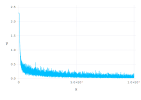

In [72]:
plot(x=1:length(train_loss_list), y=train_loss_list, Geom.line)

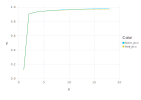

In [73]:
xs = [1:length(train_acc_list);]
y1 = train_acc_list
y2 = test_acc_list
c1 = repmat(["train_acc"], length(xs))
c2 = repmat(["test_acc"], length(xs))
plot(x=[xs;xs], y=[y1;y2], color=[c1;c2], Geom.line)